In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
plt.rcParams['figure.figsize'] = (10,10)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import seaborn as sns

In [5]:
from training_utils import iterative_pruning
from training_utils import initializer

Set Seeds

In [6]:
import tensorflow as tf

In [7]:
seed = 7531
np.random.seed(seed)
tf.random.set_seed(seed)

In [8]:
import matplotlib

In [9]:
np.where(np.linspace(-0.3,0.3,1001) == 0)

(array([500]),)

In [10]:
gnbu_b = plt.get_cmap("GnBu")(np.linspace(-0.3,0.3,1001))
gnbu_b[500,:] = np.array([0.,0.,0.,1.])
cmap = matplotlib.colors.ListedColormap(gnbu_b)

### Tensorflow

In [11]:
import tensorflow as tf
#import tensorflow_probability as tfp
from tensorflow.keras import layers

In [12]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


Masking: https://stackoverflow.com/questions/38278965/selectively-zero-weights-in-tensorflow

In [13]:
import tensorflow_datasets as tfds

In [13]:
(ds_train_mnist, ds_test_mnist), ds_info_mnist = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [14]:
#with tf.device('/CPU:0'):
(ds_train_cif10, ds_test_cif10), ds_info_cif10 = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [18]:
#@tf.function
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., tf.one_hot(label,10)

#@tf.function
def prep_data(ds, ds_info):
    ds = ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.cache()
    ds = ds.shuffle(ds_info.splits['train'].num_examples)
    ds = ds.batch(256)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds
#ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#ds_train = ds_train.cache()
#ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
#ds_train = ds_train.batch(128)
#ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

#ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#ds_test = ds_test.cache()

#ds_test = ds_test.shuffle(ds_info.splits['train'].num_examples)
#ds_test = ds_test.batch(128)
#ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [15]:
ds_train_mnist = prep_data(ds_train_mnist, ds_info_mnist)
ds_test_mnist = prep_data(ds_test_mnist, ds_info_mnist)

NameError: name 'ds_train_mnist' is not defined

In [79]:
tf.math.reduce_std(iter(ds_train_mnist).next()[0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.30938092>

In [78]:
tf.math.reduce_mean(iter(ds_train_mnist).next()[0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.12676375>

In [19]:
#with tf.device('/CPU:0'):
ds_train_cif10 = prep_data(ds_train_cif10, ds_info_cif10)
ds_test_cif10 = prep_data(ds_test_cif10, ds_info_cif10)

In [20]:
tf.math.reduce_std(iter(ds_train_cif10).next()[0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.25041717>

In [21]:
tf.math.reduce_mean(iter(ds_train_cif10).next()[0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.46289587>

# CNN

[(W−K+2P)/S]+1

In [226]:
init = initializer()

initializer


In [227]:
from custom_nn import MaskedConv2D, MaxPool2DExt, Conv2_Mask

In [228]:
from custom_nn import Linear_Mask

In [229]:
INPUT_SHAPE = iter(ds_train_cif10).next()[0].numpy().shape
SIGMOID_MULTIPLIER = [.1,.1,.2,.2,.2]

In [202]:
INPUT_SHAPE = (128, 32, 32, 3)
SIGMOID_MULTIPLIER = [.3,.3,.25,.17,.13]

In [230]:
conv2_mask = Conv2_Mask(input_shape=INPUT_SHAPE, sigmoid_multiplier=SIGMOID_MULTIPLIER)

In [24]:
conv2_mask.layers[0].weight_shape

(3, 3, 3, 64)

In [25]:
conv2_mask.layers[0].non_trainable_weights

[<tf.Variable 'weights:0' shape=(3, 3, 3, 64) dtype=float32, numpy=
 array([[[[-7.29468837e-02, -9.55662429e-02, -4.25241068e-02, ...,
           -9.89554450e-03, -1.14510417e-01,  1.28546043e-03],
          [ 7.13661015e-02,  4.78499522e-03, -1.13680437e-01, ...,
            2.53303386e-02, -4.31996509e-02,  5.48188090e-02],
          [ 6.33505806e-02,  4.89993347e-03,  3.48750013e-03, ...,
           -7.99426213e-02, -3.67756970e-02,  1.29838079e-01]],
 
         [[-6.72688941e-03, -4.45073023e-02,  6.23297645e-03, ...,
            1.10634618e-01,  8.43689516e-02,  6.51640957e-03],
          [-9.84912552e-03,  8.42087436e-03,  5.10817878e-02, ...,
            6.05998822e-02,  5.24279196e-03,  1.34619787e-01],
          [-7.06426874e-02,  3.24899033e-02, -1.33991404e-03, ...,
           -6.49030600e-03, -1.79676549e-03,  4.67323326e-02]],
 
         [[ 1.85101673e-01,  8.89737532e-02,  1.32903010e-02, ...,
            3.04171648e-02, -3.40308109e-03,  1.91397648e-02],
          [-1.45

In [26]:
conv2_mask.layers[0].get_normal_weights()

<tf.Variable 'weights:0' shape=(3, 3, 3, 64) dtype=float32, numpy=
array([[[[-7.29468837e-02, -9.55662429e-02, -4.25241068e-02, ...,
          -9.89554450e-03, -1.14510417e-01,  1.28546043e-03],
         [ 7.13661015e-02,  4.78499522e-03, -1.13680437e-01, ...,
           2.53303386e-02, -4.31996509e-02,  5.48188090e-02],
         [ 6.33505806e-02,  4.89993347e-03,  3.48750013e-03, ...,
          -7.99426213e-02, -3.67756970e-02,  1.29838079e-01]],

        [[-6.72688941e-03, -4.45073023e-02,  6.23297645e-03, ...,
           1.10634618e-01,  8.43689516e-02,  6.51640957e-03],
         [-9.84912552e-03,  8.42087436e-03,  5.10817878e-02, ...,
           6.05998822e-02,  5.24279196e-03,  1.34619787e-01],
         [-7.06426874e-02,  3.24899033e-02, -1.33991404e-03, ...,
          -6.49030600e-03, -1.79676549e-03,  4.67323326e-02]],

        [[ 1.85101673e-01,  8.89737532e-02,  1.32903010e-02, ...,
           3.04171648e-02, -3.40308109e-03,  1.91397648e-02],
         [-1.45366034e-02,  2.543

In [27]:
conv2_mask.layers[0].trainable_weights

[<tf.Variable 'mask:0' shape=(3, 3, 3, 64) dtype=float32, numpy=
 array([[[[1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.]],
 
         [[1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.]],
 
         [[1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.]]],
 
 
        [[[1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.]],
 
         [[1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.]],
 
         [[1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.]]],
 
 
        [[[1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.]],
 
         [[1., 1., 1., ..., 1., 1., 1.],
      

In [28]:
conv2_mask.layers[0].get_weights()

[array([[[[1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.]],
 
         [[1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.]],
 
         [[1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.]]],
 
 
        [[[1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.]],
 
         [[1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.]],
 
         [[1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.]]],
 
 
        [[[1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.]],
 
         [[1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1.

In [29]:
from custom_nn import FCN_Mask

In [74]:
input_dim=784
NO_LAYERS = 3
LAYER_SHAPES = np.array([[input_dim, 300], [300,100], [100,10]])
LAYER_SHAPES4 = np.array([[input_dim, 500], [500,300], [300,100], [100,10]])
SIG_MULTI = [0.28,0.17,0.1]
fcn_mask = FCN_Mask(input_dim, layer_shapes=LAYER_SHAPES, sigmoid_multiplier=SIG_MULTI, use_bernoulli_sampler=False)

NameError: name 'FCN_Mask' is not defined

In [24]:
fcn_mask.layers[0].get_weights()[0].shape

(784, 300)

In [231]:
MU=0
MU_BI = [-0.13, 0.13]
SIGMA=-3 #0.1 IF SIGMA == -1 --> glorot normal
SIGMA_BI = [-SIGMA, SIGMA]
conv2_mask, initial_weights = init.set_weights_man(conv2_mask, mode="signed_constant", constant=-2, mu=MU, sigma=-1, mu_bi=MU_BI, sigma_bi=SIGMA_BI, save_to="", weight_as_constant=True, set_mask=False) # uniform -3
#fcn, initial_weights = init.set_weights_man(fcn, mode="normal", mu=MU, sigma=SIGMA, mu_bi=MU_BI, sigma_bi=SIGMA_BI, save_to="./weights/initial_weights", weight_as_constant=True)_mas

Signed constant (std): 0.0273972602739726
Signed constant (std): 0.014925373134328358
Signed constant (std): 0.0006793478260869565
Signed constant (std): 0.00390625
Signed constant (std): 0.007518796992481203


In [232]:
conv2_mask, initial_weights = init.set_weights_man(conv2_mask, mode="uniform", constant=1, mu=MU, sigma=-3, mu_bi=MU_BI, sigma_bi=SIGMA_BI, save_to="", weight_as_constant=False, set_mask=True)

Glorot uniform with bound 0.3333
Glorot uniform with bound 0.3333
Glorot uniform with bound 0.0039
Glorot uniform with bound 0.0039
Glorot uniform with bound 0.1000


In [233]:
for layer in conv2_mask.layers:
    if layer.type == "fefo":
        print("Feed Forward with shape: ", layer.shape)
    if layer.type == "conv":
        print("Convolutional Layer with shape: ", layer.weight_shape)
    else:
        continue
        

Convolutional Layer with shape:  (3, 3, 3, 64)
Convolutional Layer with shape:  (3, 3, 64, 64)
Feed Forward with shape:  (2688, 256)
Feed Forward with shape:  (256, 256)
Feed Forward with shape:  (256, 10)


In [207]:
import gc
gc.collect()

212

In [234]:
def just_eval(model, ds_test):
    eval_acc = tf.keras.metrics.CategoricalAccuracy()
    eval_loss_mean = tf.keras.metrics.Mean()
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    for x_batch_test, y_batch_test in ds_test:
        eval_pred = model(x_batch_test)
        eval_loss = loss_fn(y_batch_test, eval_pred)

        eval_loss_mean(eval_loss)
        eval_acc(y_batch_test, eval_pred)

    print(f"Evaluation Loss: {eval_loss_mean.result().numpy()}")
    print(f"Evaluation Accuracy: {eval_acc.result().numpy()}")

In [235]:
class ModelTrainer():
    def __init__(self, model, lr):
        self.model = model
        self.loss_fn = tf.keras.losses.CategoricalCrossentropy()
        self.optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        
    @tf.function
    def train_step(self, x_batch, y_batch):
        with tf.GradientTape() as tape:
            predicted = self.model(x_batch, training=True)
            loss = self.loss_fn(y_batch, predicted)

        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        return loss, predicted

In [210]:
arr = np.zeros(1000)
arr[0] = 20
for i in range(1,1000):
    arr[i] = arr[i-1] * 0.96

In [55]:
arr

array([2.00000000e+01, 1.92000000e+01, 1.84320000e+01, 1.76947200e+01,
       1.69869312e+01, 1.63074540e+01, 1.56551558e+01, 1.50289496e+01,
       1.44277916e+01, 1.38506799e+01, 1.32966527e+01, 1.27647866e+01,
       1.22541951e+01, 1.17640273e+01, 1.12934662e+01, 1.08417276e+01,
       1.04080585e+01, 9.99173615e+00, 9.59206671e+00, 9.20838404e+00,
       8.84004868e+00, 8.48644673e+00, 8.14698886e+00, 7.82110931e+00,
       7.50826493e+00, 7.20793434e+00, 6.91961696e+00, 6.64283229e+00,
       6.37711899e+00, 6.12203423e+00, 5.87715286e+00, 5.64206675e+00,
       5.41638408e+00, 5.19972872e+00, 4.99173957e+00, 4.79206999e+00,
       4.60038719e+00, 4.41637170e+00, 4.23971683e+00, 4.07012816e+00,
       3.90732303e+00, 3.75103011e+00, 3.60098891e+00, 3.45694935e+00,
       3.31867138e+00, 3.18592452e+00, 3.05848754e+00, 2.93614804e+00,
       2.81870212e+00, 2.70595403e+00, 2.59771587e+00, 2.49380724e+00,
       2.39405495e+00, 2.29829275e+00, 2.20636104e+00, 2.11810660e+00,
      

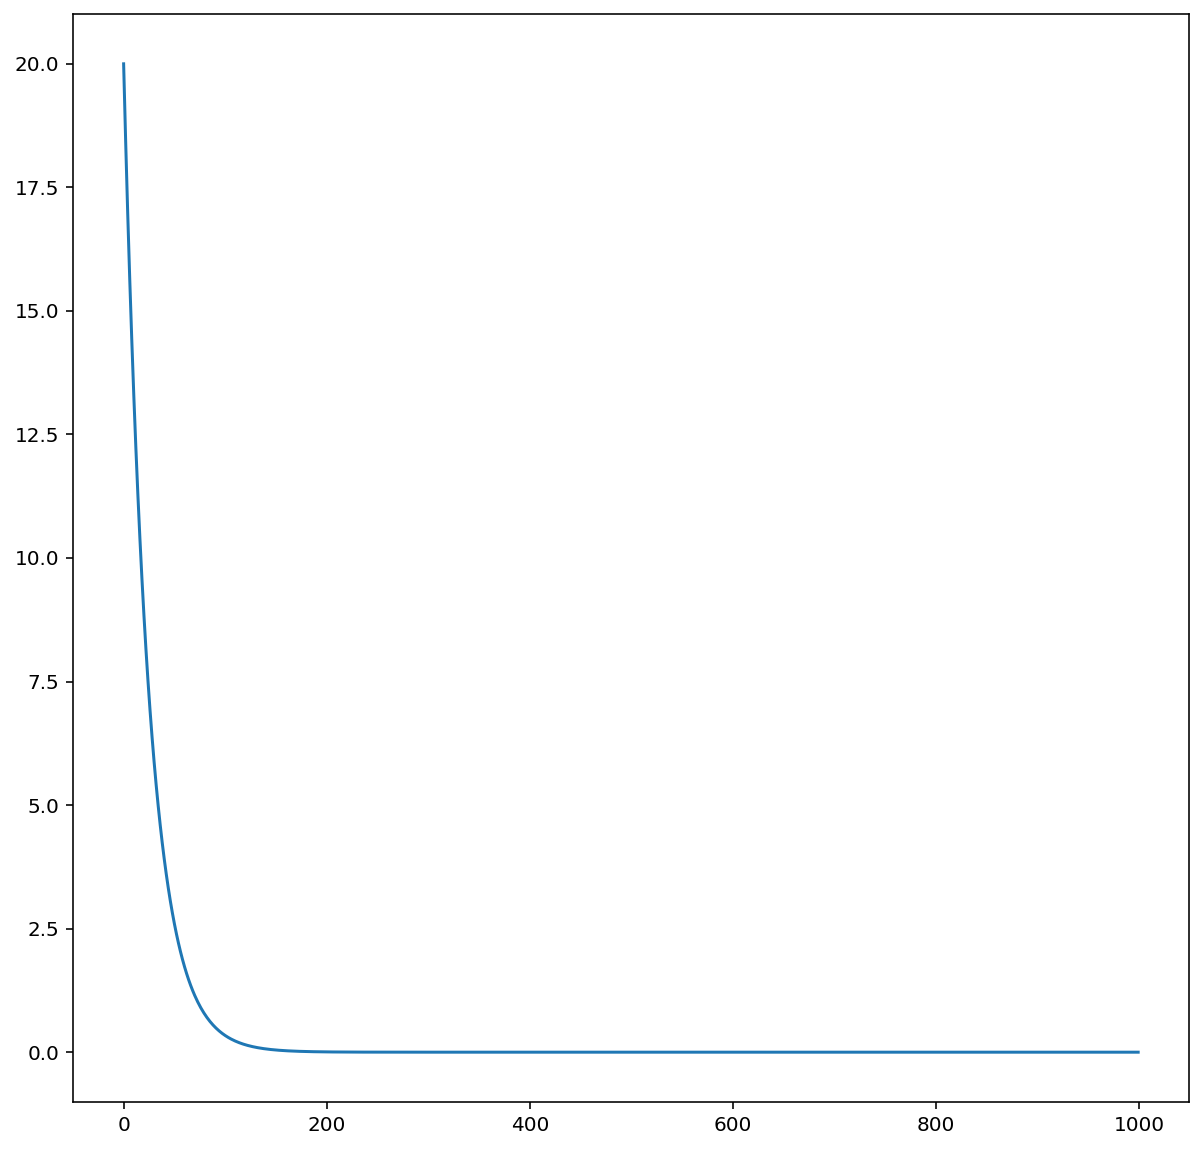

In [56]:
plt.plot(arr)

In [236]:
#@tf.function
def train_supermask_model(model, ds_train, epochs=6, prune_neurons=False, keep_input=True):
    
    lr1 = 30.
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    lr1, decay_steps=100000, decay_rate=0.99, staircase=True
    )

    #optimizer = tf.keras.optimizers.SGD(learning_rate=lr1, momentum=0.9)
    
    #loss_fn = tf.keras.losses.CategoricalCrossentropy()
    loss_metric = tf.keras.metrics.Mean()
    acc_metric = tf.keras.metrics.CategoricalAccuracy()
    
    loss_history = []
    acc_history = []
    
    remaining_ones_ratio_history = []
    
    with tf.device('/CPU:0'):
        layerwise_output_all = []
        gradient_history = []
        mask_history = []
    
    mt = ModelTrainer(model, lr=lr_schedule)
    
    epoch_half = epochs // 2
    epoch_quarter = epoch_half // 2
    
    for epoch in range(epochs):
        
        #if epoch == epoch_half:
        #    mt.update_lr(lr1/2)
            #optimizer = tf.keras.optimizers.SGD(learning_rate=lr1/2, momentum=0.9)
        #elif epoch == (epoch_half+epoch_quarter):
        #    mt.update_lr(lr1/4)
            #optimizer = tf.keras.optimizers.SGD(learning_rate=lr1/4, momentum=0.9)
    
        #print(f"Start of epoch {epoch+1}")

        # Iterate over the batches of the dataset.
        for step, (x_batch_train,y_batch_train) in enumerate(ds_train):
#            with tf.GradientTape() as tape:
#                predicted, layerwise_output = model(x_batch_train, training=True) #, epoch
#                layerwise_output_all.append(layerwise_output)
                # Compute reconstruction loss
#                loss = loss_fn(y_batch_train, predicted)

 #           grads = tape.gradient(loss, model.trainable_weights)
            #print(grads)
            #print("gradient mean", tf.reduce_mean(grads))
            #gradient_history.append([tf.reduce_mean(g).numpy() for g in grads])
            #mask_weights = [var for var in model.trainable_weights if "kernel" not in var.name]
#            optimizer.apply_gradients(zip(grads, model.trainable_weights))
            loss, predicted = mt.train_step(x_batch_train, y_batch_train)

            loss_metric(loss)

            acc_metric(y_batch_train,predicted)
        
        #gc.collect()
        
        #with tf.device('/CPU:0'):
        #print(model.layers[0].mask)
        mask_history.append([layer.bernoulli_mask for layer in model.layers if layer.type is "conv" or layer.type is "fefo"])
        loss_history.append(loss_metric.result().numpy())
        acc_history.append(acc_metric.result().numpy())
        
        #save the last gradient of each epoch
        #gradient_history.append(grads)
            
        print(f"End of Epoch: {epoch+1}: Accuracy = {acc_metric.result().numpy():.6f} --- Mean Loss = {loss_metric.result().numpy():.6f}")
        
        
        
        #if epoch % 20 == 0:
        #    global_no_ones = np.sum([np.sum(layer.bernoulli_mask) for layer in model.layers if layer.type == "fefo" or layer.type == "conv"])
        #    global_size = np.sum([tf.size(layer.bernoulli_mask) for layer in model.layers if layer.type == "fefo" or layer.type == "conv"])

        #    remaining_ones_ratio = (global_no_ones/global_size)*100
        #    print(f"{remaining_ones_ratio:.2f}% of weights are 'remaining'")
            #remaining_ones_ratio_history.append(remaining_ones_ratio)

    return model, loss_history, acc_history, mask_history #, layerwise_output_all, gradient_history, remaining_ones_ratio_history, mask_history

https://github.com/tensorflow/tensorflow/issues/32707  
https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

In [183]:
len(conv2_mask.trainable_weights)

5

In [184]:
for w in conv2_mask.trainable_weights:
    print(w.name, w.shape)

mask:0 (3, 3, 3, 64)
mask:0 (3, 3, 64, 64)
mask:0 (2688, 256)
mask:0 (256, 256)
mask:0 (256, 10)


In [185]:
for w in conv2_mask.non_trainable_weights:
    print(w.name, w.shape)

bias:0 (64,)
weights:0 (3, 3, 3, 64)
bias:0 (64,)
weights:0 (3, 3, 64, 64)
b:0 (256,)
w:0 (2688, 256)
b:0 (256,)
w:0 (256, 256)
b:0 (10,)
w:0 (256, 10)


In [237]:
conv2_mask, loss_history_mask, acc_history_mask, mask_history = train_supermask_model(conv2_mask, ds_train_cif10, epochs=1000) #, layerwise_output_all, gradient_history, ones_ratio_history, mask_history

End of Epoch: 1: Accuracy = 0.115400 --- Mean Loss = 2.302583
End of Epoch: 2: Accuracy = 0.136860 --- Mean Loss = 2.302569
End of Epoch: 3: Accuracy = 0.151000 --- Mean Loss = 2.302572
End of Epoch: 4: Accuracy = 0.161110 --- Mean Loss = 2.302557
End of Epoch: 5: Accuracy = 0.167728 --- Mean Loss = 2.302544
End of Epoch: 6: Accuracy = 0.171040 --- Mean Loss = 2.302535
End of Epoch: 7: Accuracy = 0.173180 --- Mean Loss = 2.302529
End of Epoch: 8: Accuracy = 0.174997 --- Mean Loss = 2.302524
End of Epoch: 9: Accuracy = 0.176578 --- Mean Loss = 2.302509
End of Epoch: 10: Accuracy = 0.177612 --- Mean Loss = 2.302483
End of Epoch: 11: Accuracy = 0.178589 --- Mean Loss = 2.302461
End of Epoch: 12: Accuracy = 0.178292 --- Mean Loss = 2.302421
End of Epoch: 13: Accuracy = 0.176757 --- Mean Loss = 2.302358
End of Epoch: 14: Accuracy = 0.175226 --- Mean Loss = 2.302244
End of Epoch: 15: Accuracy = 0.173084 --- Mean Loss = 2.301984
End of Epoch: 16: Accuracy = 0.170706 --- Mean Loss = 2.300412
E

In [241]:
conv2_mask.layers[0].bernoulli_mask

AttributeError: 'Operation' object has no attribute '_c_op'

In [242]:
for layer in conv2_mask.layers:
    print(layer.type)
    if layer.type == "conv" or layer.type == "fefo":
        print(layer.bernoulli_mask)

conv


AttributeError: 'Operation' object has no attribute '_c_op'

In [223]:
global_no_ones = np.sum([np.sum(layer.bernoulli_mask) for layer in conv2_mask.layers if layer.type == "fefo" or layer.type == "conv"])
global_size = np.sum([tf.size(layer.bernoulli_mask) for layer in conv2_mask.layers if layer.type == "fefo" or layer.type == "conv"])

remaining_ones_ratio = (global_no_ones/global_size)*100
print(f"{remaining_ones_ratio:.2f}% of weights are 'remaining'")

20.76% of weights are 'remaining'


In [243]:
just_eval(conv2_mask, ds_test_cif10)

Evaluation Loss: 1.3144924640655518
Evaluation Accuracy: 0.6208999752998352


In [90]:
import seaborn as sns

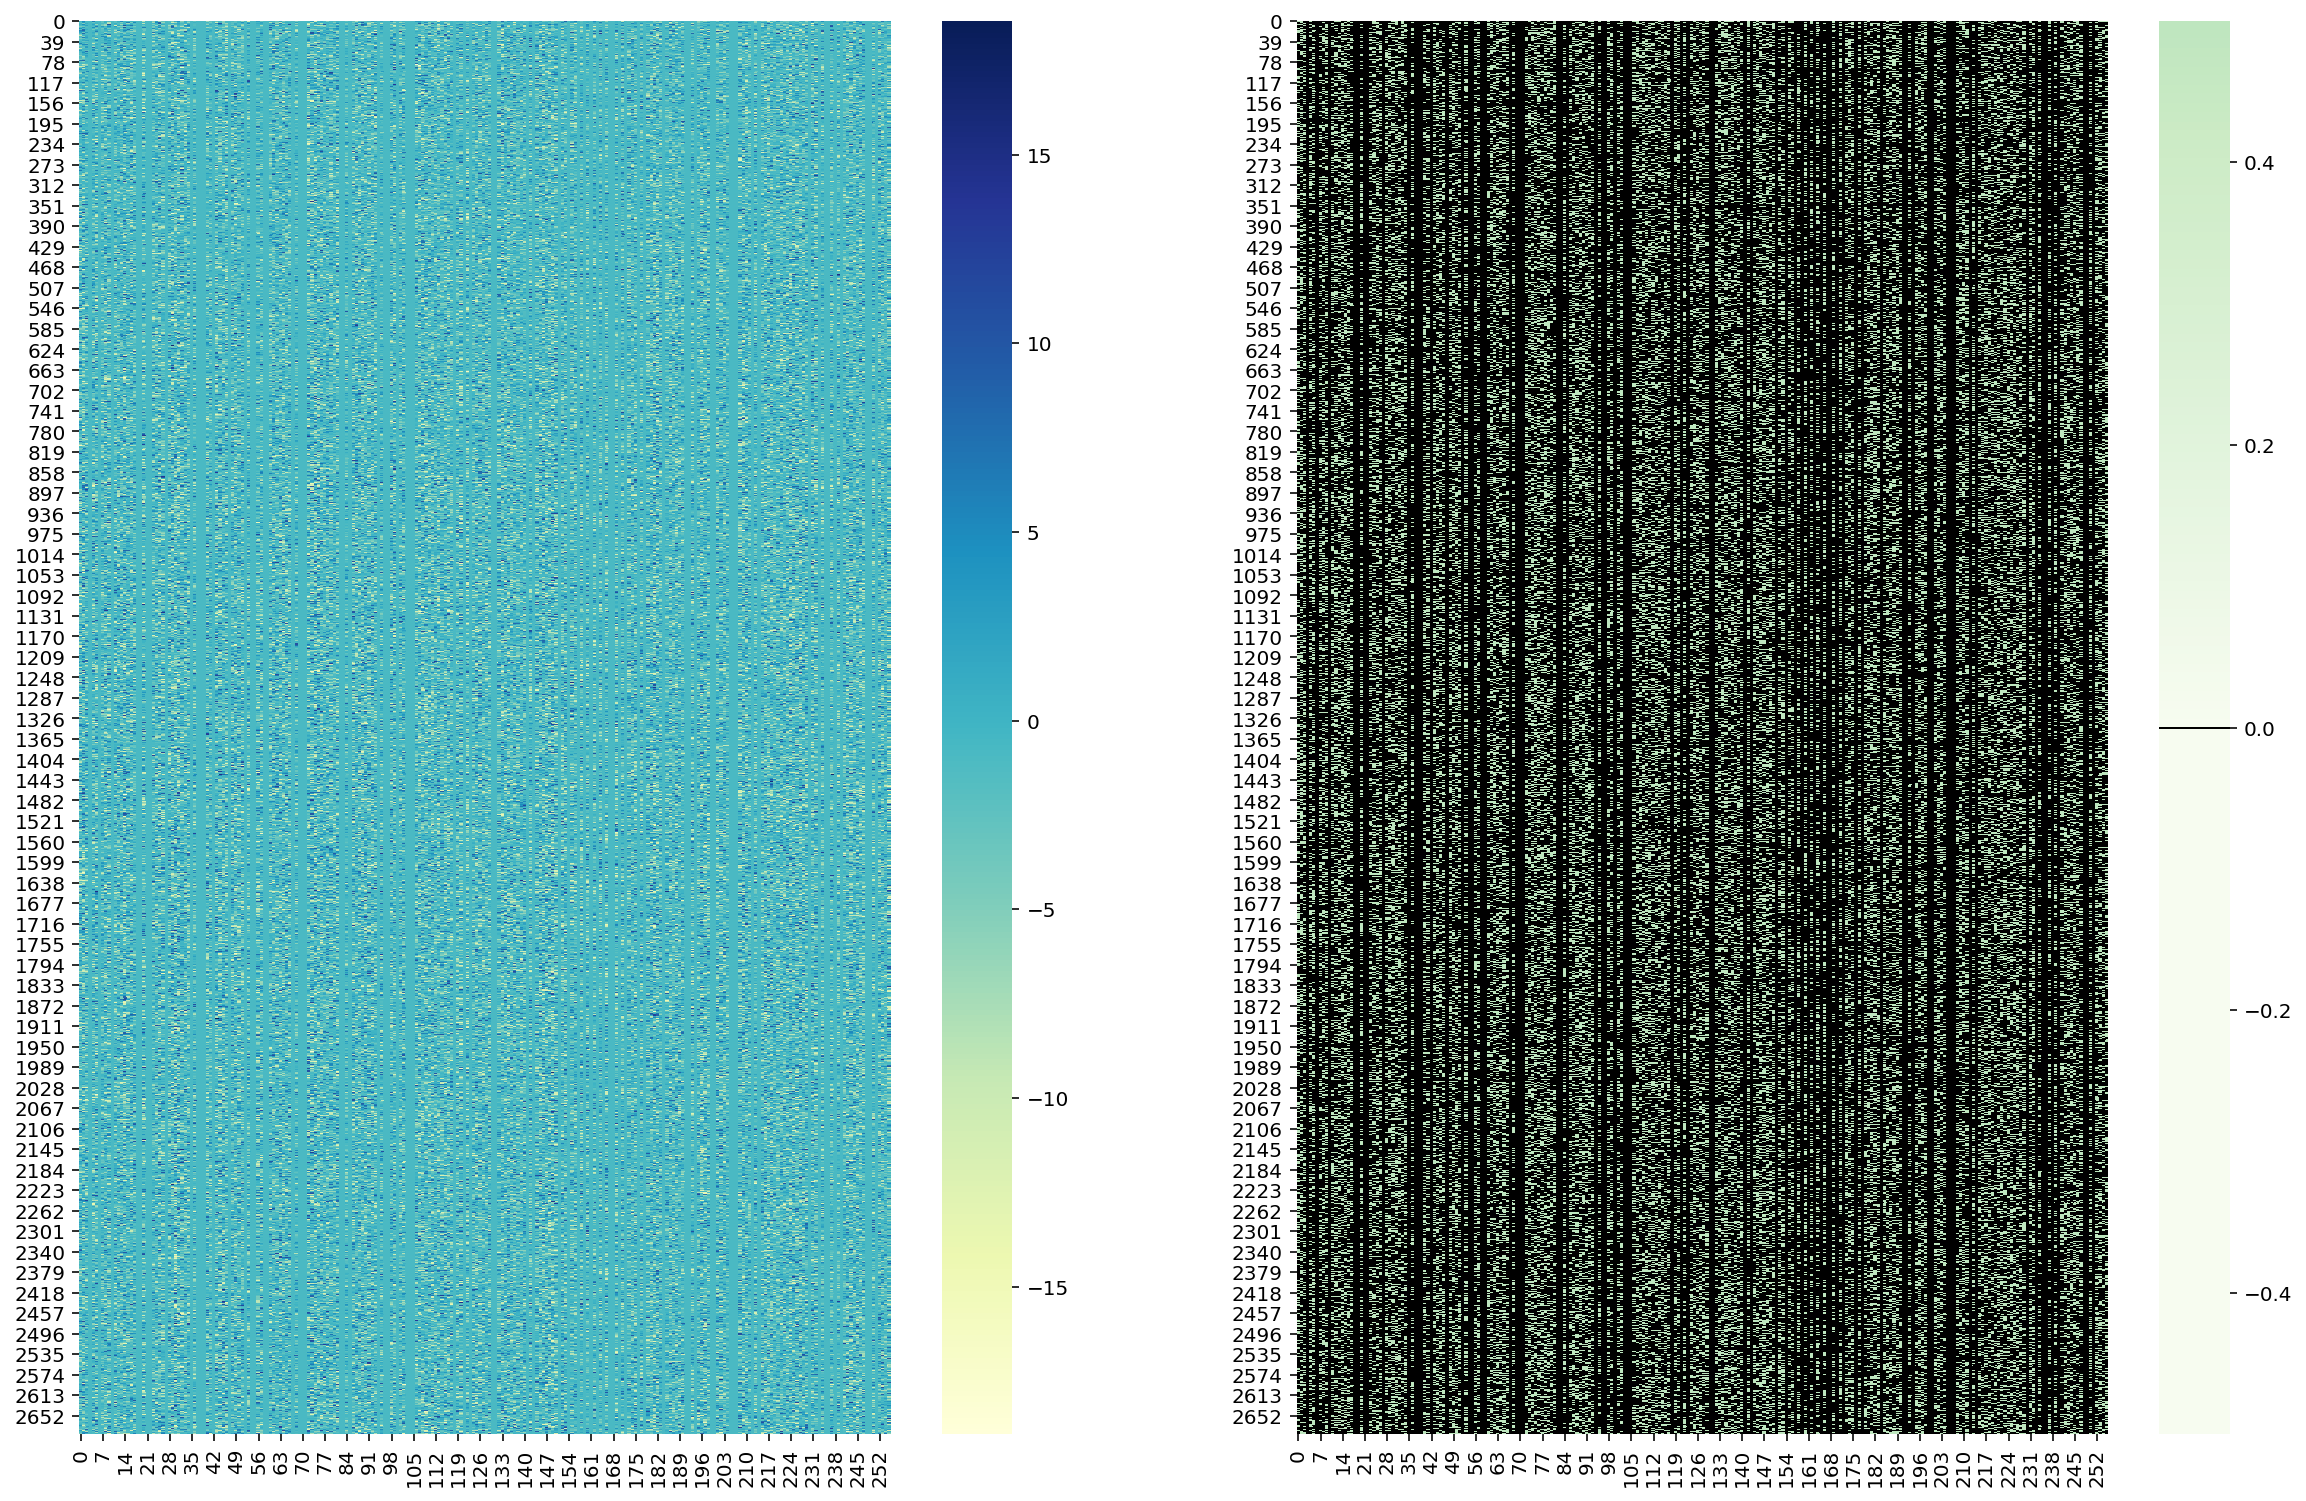

In [225]:
plt.figure(figsize=(20,13))
plt.subplot(1,2,1)
sns.heatmap(conv2_mask.layers[4].mask.numpy(),cbar=True, cmap="YlGnBu")
plt.subplot(1,2,2)
sns.heatmap(conv2_mask.layers[4].bernoulli_mask.numpy(),cmap=cmap, vmin=-0.5, vmax=0.5)

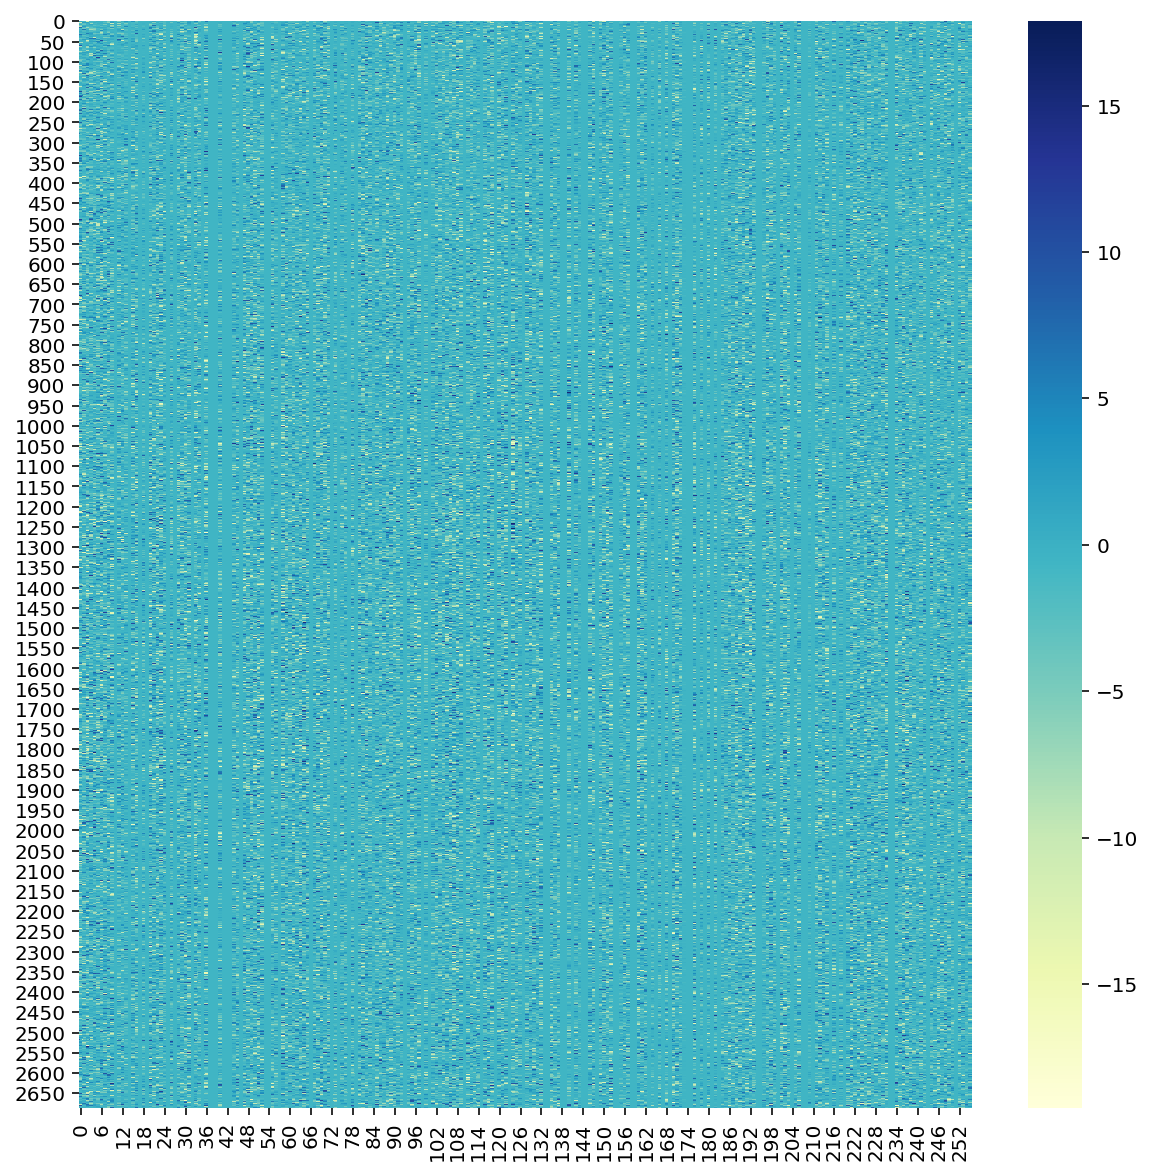

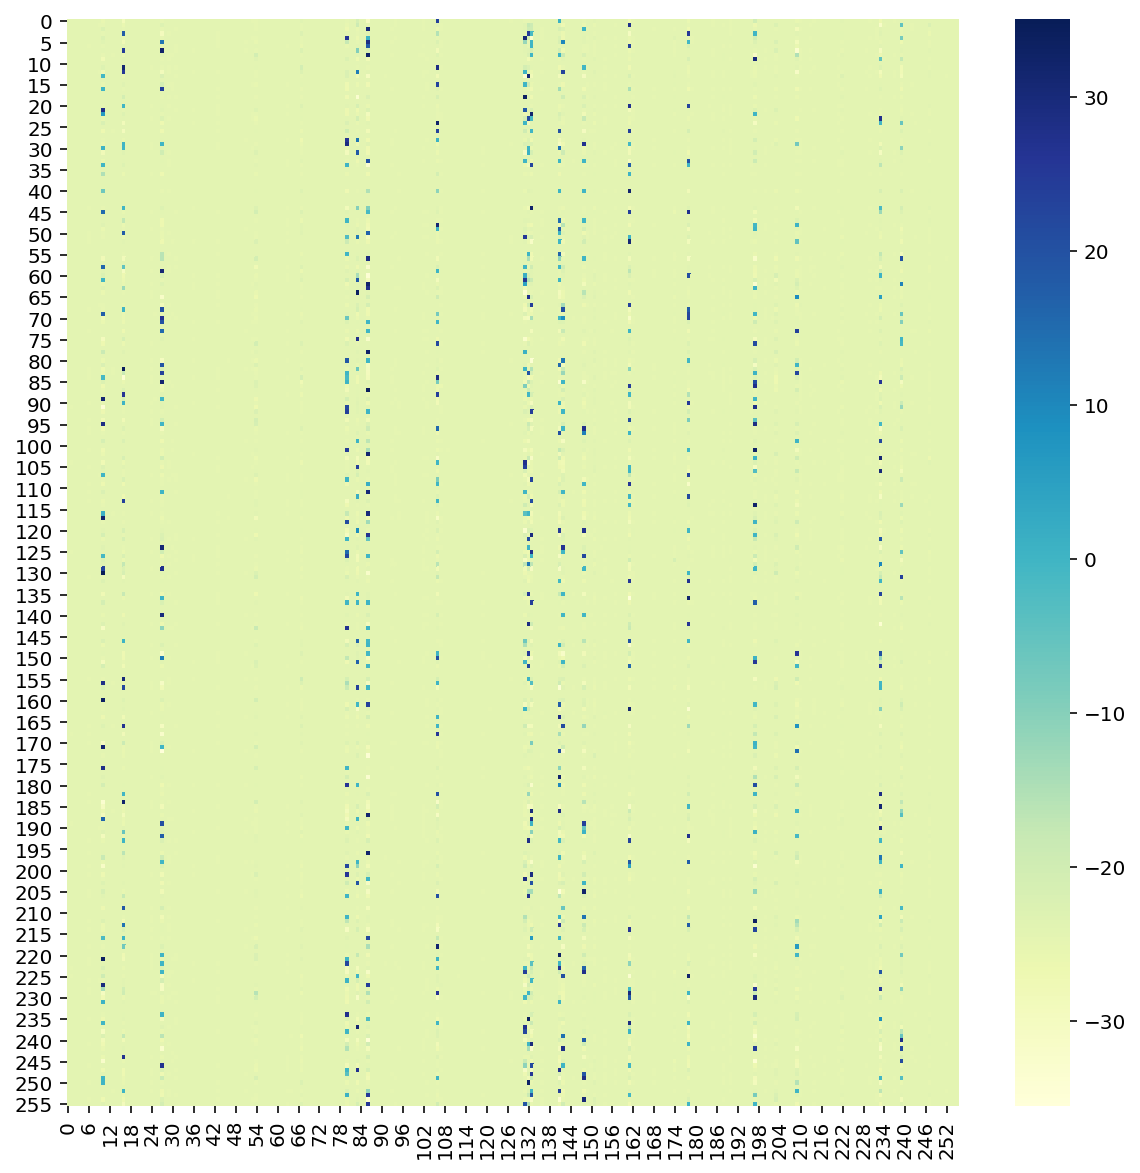

In [189]:
sns.heatmap(conv2_mask.layers[5].mask.numpy(),cbar=True, cmap="YlGnBu")

In [103]:
INPUT_SHAPE[0:]

(128, 32, 32, 3)

In [107]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=INPUT_SHAPE[1:], batch_size=256))
model.add(conv2_mask.layers[0])
#model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

In [190]:
test_img = iter(ds_train_cif10).next()[0][0]

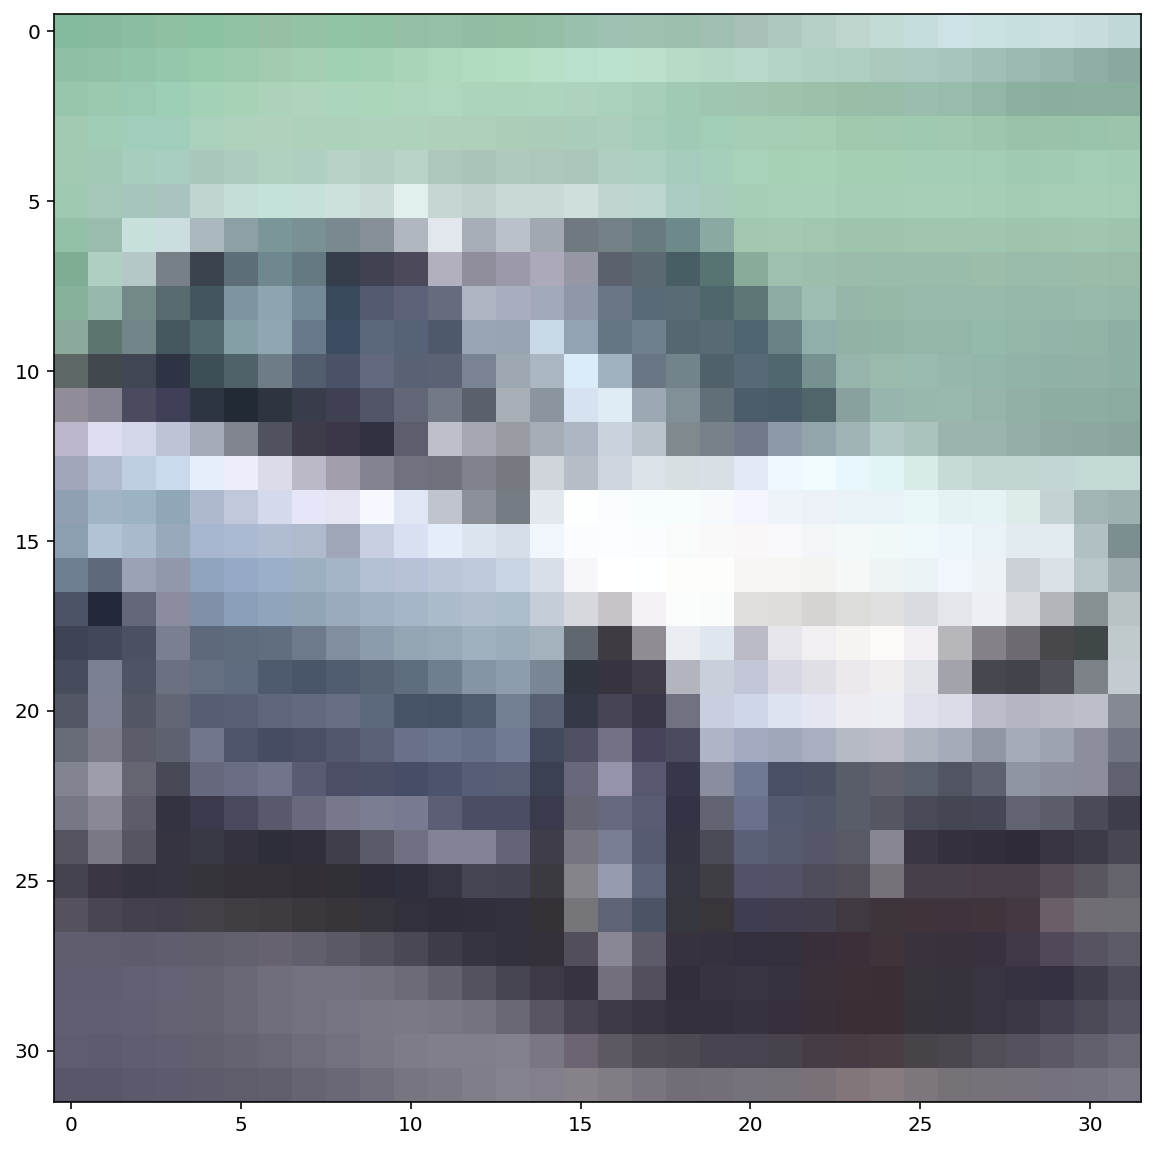

In [191]:
plt.imshow(test_img)

In [192]:
test = model(tf.expand_dims(test_img, axis=0))

In [193]:
test0 = test[0].numpy()

In [161]:
test0.shape

(30, 15, 64)

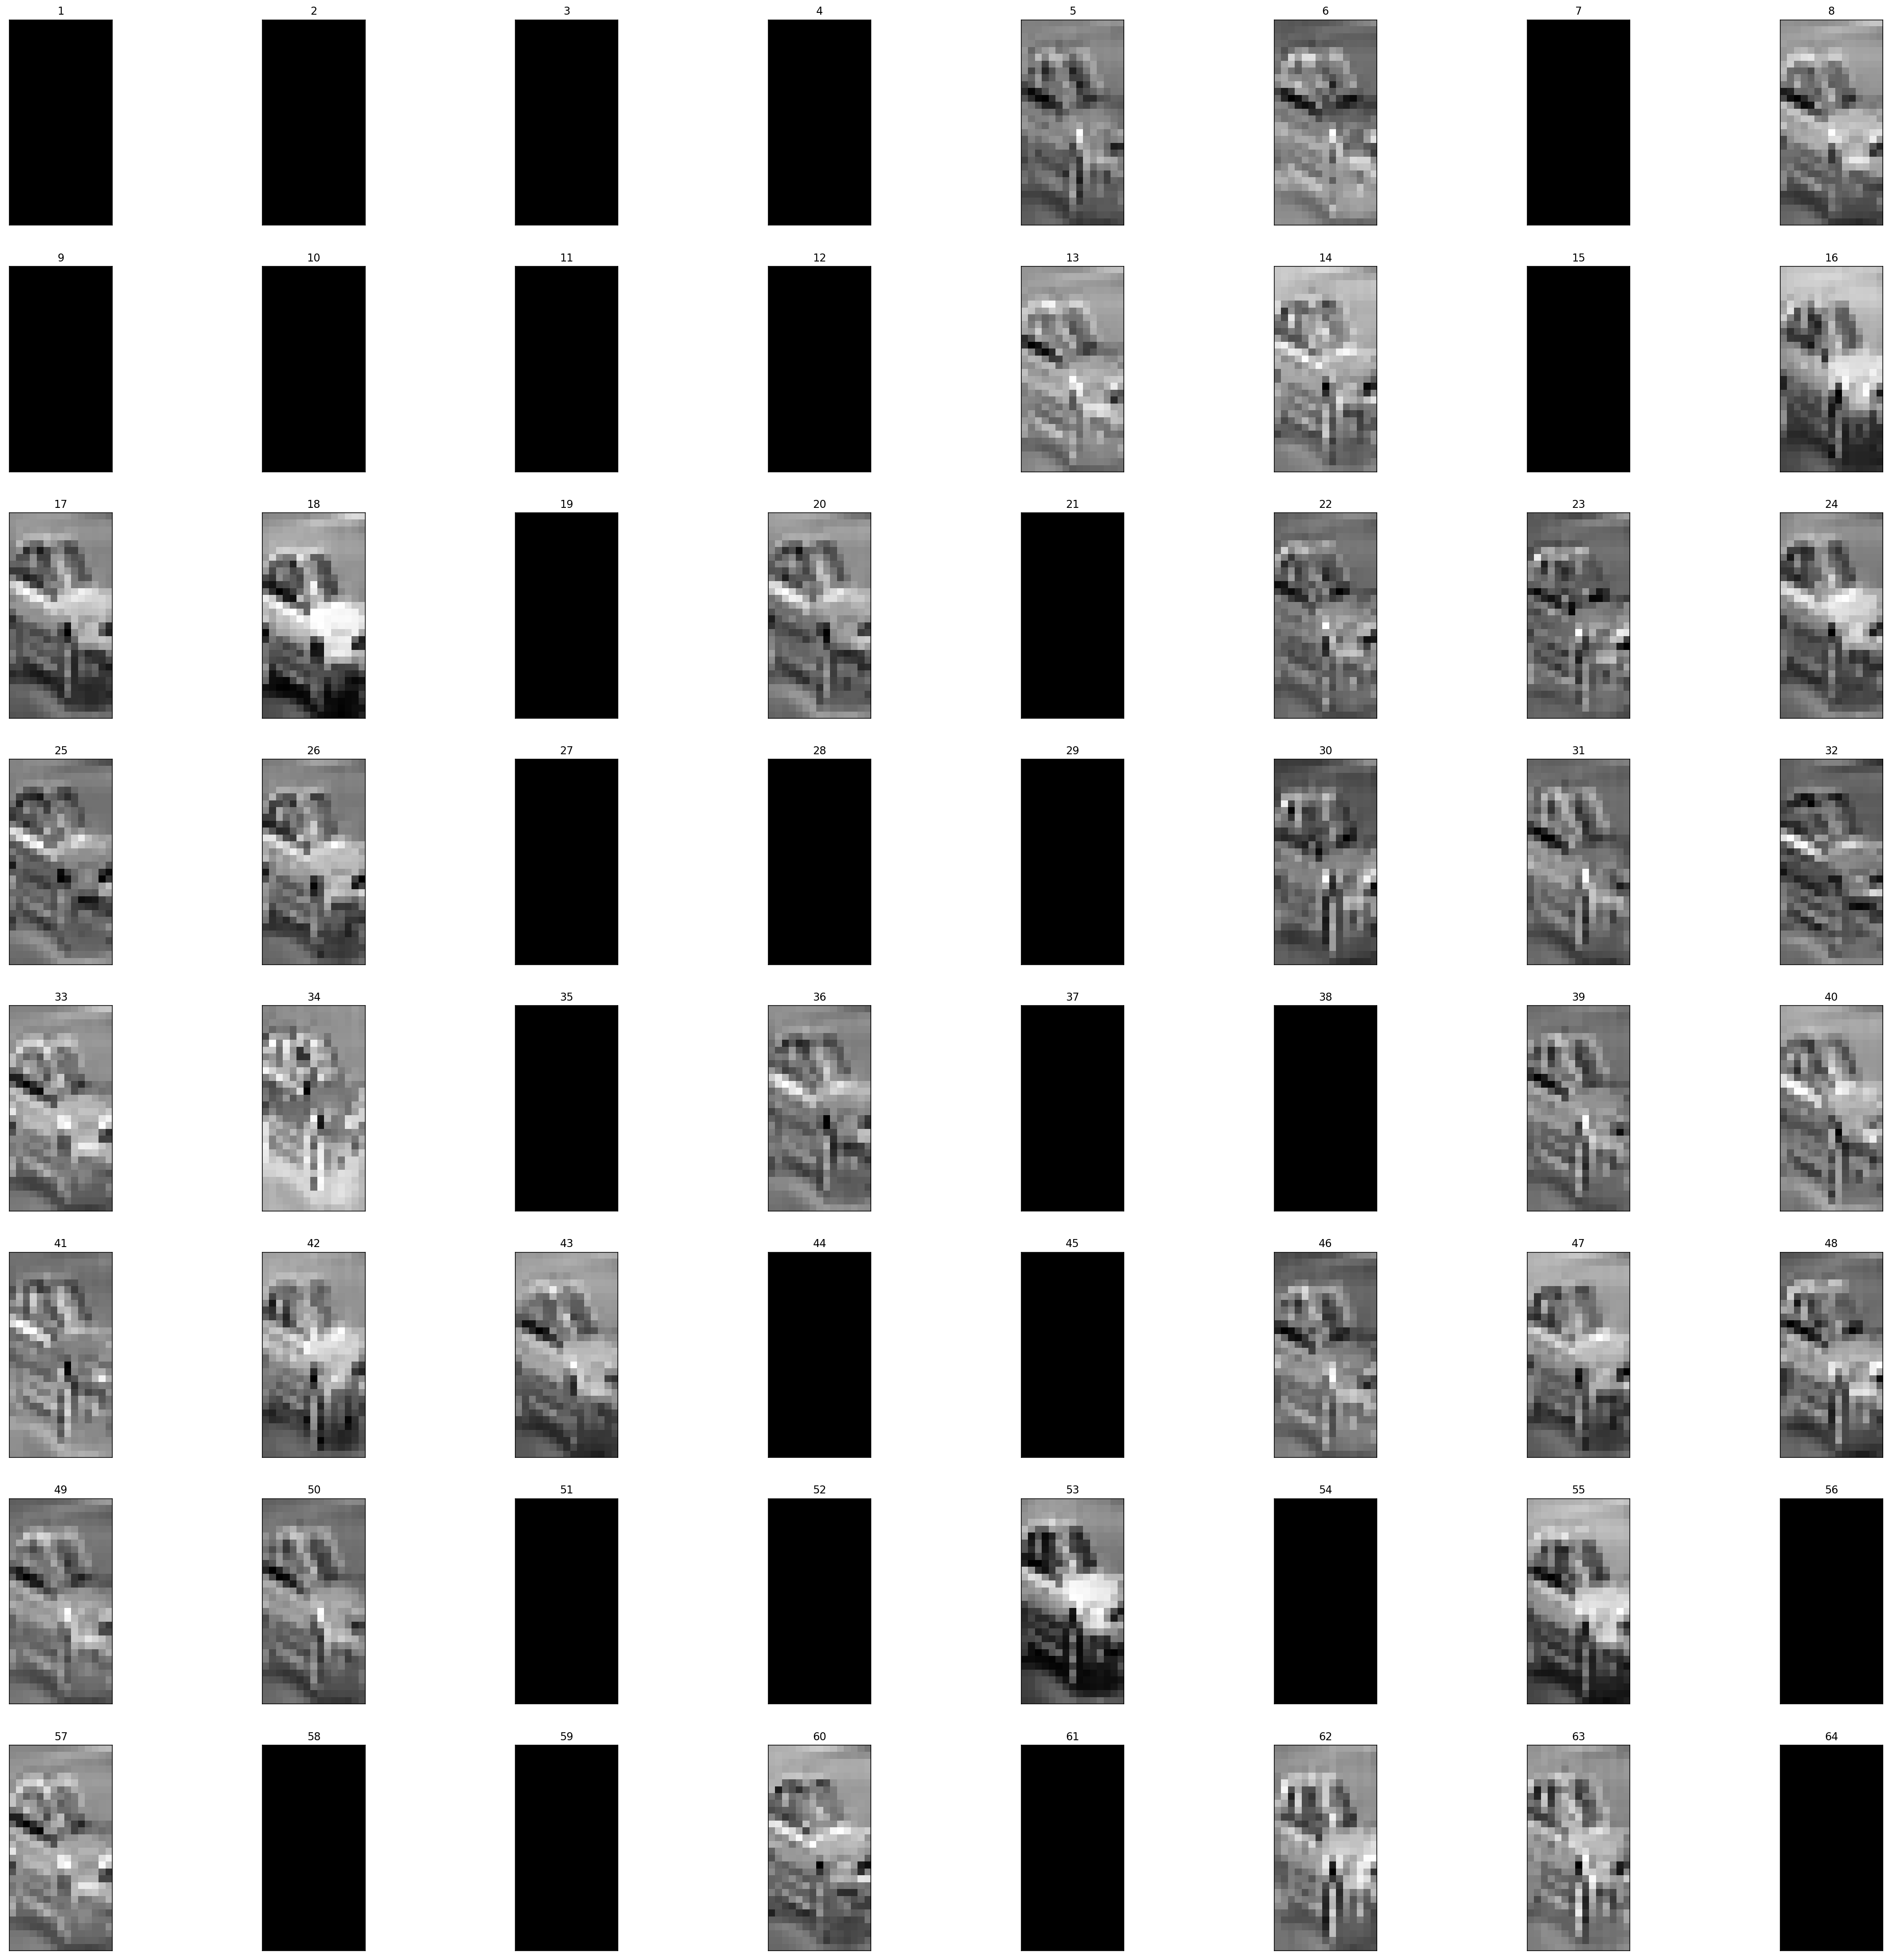

In [194]:
square = 8
ix = 1
plt.figure(figsize=(40,40))
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.title(ix)
        # plot filter channel in grayscale
        plt.imshow(test0[:, :, ix-1], cmap='gray')
        ix += 1

In [55]:
a = 0
b = 1

mask_history[0,0,a,:,:,10]

TypeError: list indices must be integers or slices, not tuple

In [58]:
channel = 0
filters = 63
mask_history[0][0][channel,:,:,filters]

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 0., 1.],
       [0., 0., 0.],
       [1., 0., 0.]], dtype=float32)>

In [61]:
tf.reduce_sum(mask_history[0][0], axis=-1)

<tf.Tensor: shape=(3, 3, 3), dtype=float32, numpy=
array([[[26., 20., 30.],
        [25., 18., 26.],
        [34., 22., 24.]],

       [[27., 32., 27.],
        [23., 25., 24.],
        [28., 24., 28.]],

       [[21., 26., 29.],
        [25., 33., 24.],
        [23., 26., 23.]]], dtype=float32)>

In [62]:
mask_history[0][0].shape

TensorShape([3, 3, 3, 64])

In [ ]:
mask_history[-1][2]

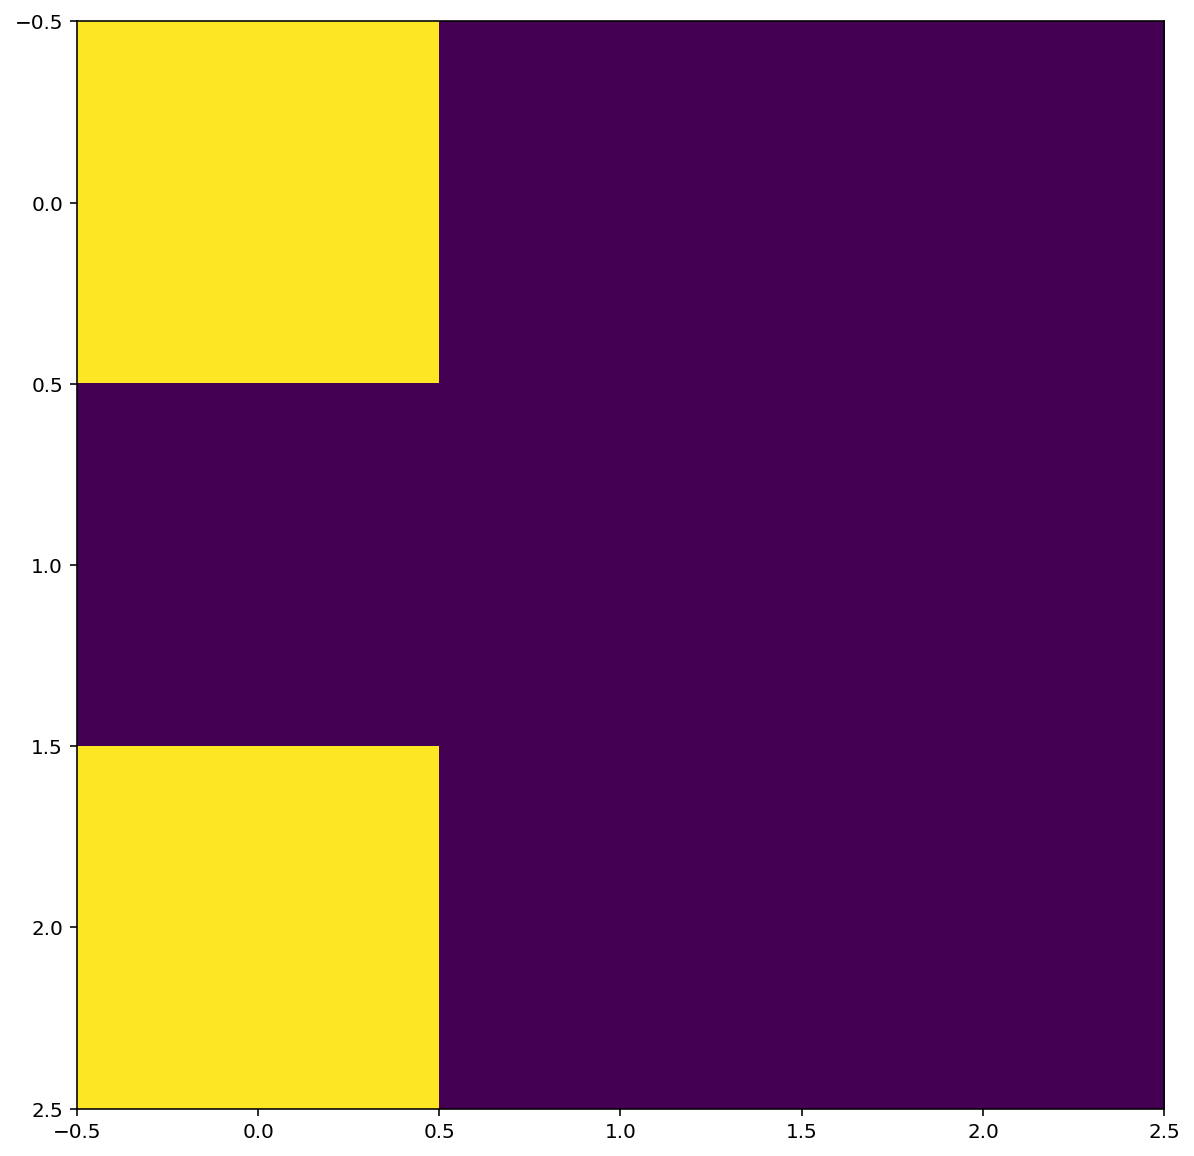

In [59]:
for channel in range(mask_history[0][0].shape[0]):
    for filters in range(mask_history[0][0].shape[-1]):
        plt.imshow(mask_history[0][0][channel,:,:,filters])

In [38]:
fcn_mask.layers[0].output

AttributeError: Layer conv_in has no inbound nodes.

In [297]:
x, layer_out = test(iter(ds_train_cif10).next()[0])

In [298]:
x

<tf.Tensor: shape=(128, 10), dtype=float32, numpy=
array([[0.10327648, 0.06267342, 0.05225683, ..., 0.11587001, 0.14315353,
        0.15664676],
       [0.10937632, 0.06725454, 0.05979786, ..., 0.11515807, 0.16146076,
        0.16512643],
       [0.09326565, 0.08717821, 0.05079903, ..., 0.11886841, 0.14460754,
        0.1451218 ],
       ...,
       [0.08943109, 0.08698727, 0.05388276, ..., 0.13217412, 0.1264147 ,
        0.15845174],
       [0.08496665, 0.09950992, 0.04160346, ..., 0.12306143, 0.15474327,
        0.1632188 ],
       [0.09280412, 0.07776964, 0.04430648, ..., 0.12087853, 0.15411909,
        0.16789721]], dtype=float32)>

In [238]:
iter(ds_train_mnist).next()[0].shape

TensorShape([128, 28, 28, 1])

In [239]:
iter(ds_train_cif10).next()[0].shape

TensorShape([128, 32, 32, 3])

In [53]:
mc = MaskedConv2D(filters=64, kernel_size=3, input_shape=INPUT_SHAPE, use_bias=False)

In [54]:
mc.out_shape

(128, 26, 13, 64)

In [55]:
mc.get_mask(as_logit=True)

<tf.Variable 'Variable:0' shape=(3, 3, 1, 64) dtype=float32, numpy=
array([[[[-4.30549085e-02, -9.87380147e-02,  8.25221166e-02,
          -5.88331930e-02, -3.56055461e-02,  2.41851844e-02,
           7.58366520e-03,  2.63399072e-02, -2.32688673e-02,
          -3.73841785e-02,  4.38836329e-02, -1.18723987e-02,
          -5.58252707e-02,  4.24915701e-02,  4.54991013e-02,
          -1.32199889e-02, -3.15771401e-02,  4.50575585e-03,
          -6.11123852e-02, -1.28976256e-02, -5.62764183e-02,
          -1.46060862e-04,  9.55470055e-02, -6.28002509e-02,
           5.77987023e-02,  1.61521230e-03,  4.45618900e-03,
          -1.70882940e-02,  1.01895267e-02,  6.32925890e-04,
           2.28676144e-02, -4.09628861e-02,  5.12597971e-02,
          -1.66248288e-02,  3.01541369e-02, -5.42329811e-02,
          -1.93796437e-02,  2.03722827e-02, -2.31280029e-02,
           5.82759641e-02, -1.18435398e-01,  5.78222536e-02,
          -3.14842276e-02,  6.86872527e-02,  3.39128301e-02,
          -9.8119

In [56]:
mc.set_weights

<bound method Layer.set_weights of <custom_nn.MaskedConv2D object at 0x7f446c048d90>>

In [57]:
3*3*1*64

576

In [58]:
mc.get_weights()

[array([[[[-4.30549085e-02, -9.87380147e-02,  8.25221166e-02,
           -5.88331930e-02, -3.56055461e-02,  2.41851844e-02,
            7.58366520e-03,  2.63399072e-02, -2.32688673e-02,
           -3.73841785e-02,  4.38836329e-02, -1.18723987e-02,
           -5.58252707e-02,  4.24915701e-02,  4.54991013e-02,
           -1.32199889e-02, -3.15771401e-02,  4.50575585e-03,
           -6.11123852e-02, -1.28976256e-02, -5.62764183e-02,
           -1.46060862e-04,  9.55470055e-02, -6.28002509e-02,
            5.77987023e-02,  1.61521230e-03,  4.45618900e-03,
           -1.70882940e-02,  1.01895267e-02,  6.32925890e-04,
            2.28676144e-02, -4.09628861e-02,  5.12597971e-02,
           -1.66248288e-02,  3.01541369e-02, -5.42329811e-02,
           -1.93796437e-02,  2.03722827e-02, -2.31280029e-02,
            5.82759641e-02, -1.18435398e-01,  5.78222536e-02,
           -3.14842276e-02,  6.86872527e-02,  3.39128301e-02,
           -9.81193259e-02,  8.59625861e-02, -1.50663659e-01,
        

In [59]:
mc.get_weights()

[array([[[[-4.30549085e-02, -9.87380147e-02,  8.25221166e-02,
           -5.88331930e-02, -3.56055461e-02,  2.41851844e-02,
            7.58366520e-03,  2.63399072e-02, -2.32688673e-02,
           -3.73841785e-02,  4.38836329e-02, -1.18723987e-02,
           -5.58252707e-02,  4.24915701e-02,  4.54991013e-02,
           -1.32199889e-02, -3.15771401e-02,  4.50575585e-03,
           -6.11123852e-02, -1.28976256e-02, -5.62764183e-02,
           -1.46060862e-04,  9.55470055e-02, -6.28002509e-02,
            5.77987023e-02,  1.61521230e-03,  4.45618900e-03,
           -1.70882940e-02,  1.01895267e-02,  6.32925890e-04,
            2.28676144e-02, -4.09628861e-02,  5.12597971e-02,
           -1.66248288e-02,  3.01541369e-02, -5.42329811e-02,
           -1.93796437e-02,  2.03722827e-02, -2.31280029e-02,
            5.82759641e-02, -1.18435398e-01,  5.78222536e-02,
           -3.14842276e-02,  6.86872527e-02,  3.39128301e-02,
           -9.81193259e-02,  8.59625861e-02, -1.50663659e-01,
        

In [60]:
mc.trainable_weights

[<tf.Variable 'Variable:0' shape=(3, 3, 1, 64) dtype=float32, numpy=
 array([[[[-4.30549085e-02, -9.87380147e-02,  8.25221166e-02,
           -5.88331930e-02, -3.56055461e-02,  2.41851844e-02,
            7.58366520e-03,  2.63399072e-02, -2.32688673e-02,
           -3.73841785e-02,  4.38836329e-02, -1.18723987e-02,
           -5.58252707e-02,  4.24915701e-02,  4.54991013e-02,
           -1.32199889e-02, -3.15771401e-02,  4.50575585e-03,
           -6.11123852e-02, -1.28976256e-02, -5.62764183e-02,
           -1.46060862e-04,  9.55470055e-02, -6.28002509e-02,
            5.77987023e-02,  1.61521230e-03,  4.45618900e-03,
           -1.70882940e-02,  1.01895267e-02,  6.32925890e-04,
            2.28676144e-02, -4.09628861e-02,  5.12597971e-02,
           -1.66248288e-02,  3.01541369e-02, -5.42329811e-02,
           -1.93796437e-02,  2.03722827e-02, -2.31280029e-02,
            5.82759641e-02, -1.18435398e-01,  5.78222536e-02,
           -3.14842276e-02,  6.86872527e-02,  3.39128301e-02,
 

In [61]:
mc.non_trainable_weights

[<tf.Variable 'Variable:0' shape=(3, 3, 1, 64) dtype=float32, numpy=
 array([[[[ 0.06524039,  0.09070961, -0.03392106, -0.03798829,
            0.00492183,  0.01082622,  0.03999299,  0.02317412,
           -0.07749361,  0.00782654,  0.05761006, -0.05228462,
            0.01083441,  0.05870349,  0.07531562, -0.01971643,
           -0.02830264, -0.05419139,  0.08978821,  0.0461692 ,
           -0.01633086,  0.00431861, -0.01476197, -0.07867516,
           -0.0823853 , -0.08116492,  0.06094109,  0.04125399,
           -0.01254446,  0.01463621, -0.00706716, -0.03315062,
           -0.01356845,  0.00458248, -0.03665462, -0.03141736,
           -0.0371236 , -0.02497433, -0.01197346, -0.01053368,
           -0.04889293,  0.08293208,  0.02135742, -0.09017786,
            0.05083613, -0.02987114,  0.05883196, -0.00384949,
            0.03139707, -0.10422887, -0.01353978,  0.01707678,
           -0.0919968 , -0.01707014,  0.00794747, -0.0366854 ,
            0.01270528, -0.05380801, -0.04542204,

In [62]:
test = tf.cast(iter(ds_train_mnist).next()[0], tf.float32)

In [63]:
test.shape

TensorShape([128, 28, 28, 1])

In [64]:
mc(test)

UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above. [Op:Conv2D]

In [252]:
mc.out_shape

(128, 30, 15, 64)

In [253]:
test_maxpool = MaxPool2DExt(input_shape = mc.out_shape, pool_size=(2, 2), strides=None, padding='valid', data_format=None)

In [254]:
test_maxpool.out_shape

(128, 15, 7, 64)

In [255]:
MaxPool2DExt(input_shape = mc.out_shape, pool_size=(2, 2), strides=None, padding='valid', data_format=None
)(mc(test))

Shape mask:  (3, 3, 3, 64)
kernel shape:  (3, 3, 3, 64)
input type:  <dtype: 'float32'>
kernel type:  <dtype: 'float32'>


<tf.Tensor: shape=(128, 15, 7, 64), dtype=float32, numpy=
array([[[[-1.96953103e-01,  4.57083294e-03, -4.06591818e-02, ...,
           1.24540702e-01,  1.31059168e-02, -2.21784711e-02],
         [-1.76682308e-01,  1.12280967e-02, -4.10067551e-02, ...,
           1.21692300e-01,  1.97234582e-02, -3.07511184e-02],
         [-1.50002584e-01,  2.45225411e-02, -3.70416790e-02, ...,
           1.82082012e-01,  4.48386930e-02, -1.16773844e-02],
         ...,
         [-1.29290432e-01,  1.41991386e-02, -1.97706446e-02, ...,
           9.98345837e-02,  3.36731412e-02, -2.21954454e-02],
         [-1.14069469e-01,  1.04040215e-02, -2.69249752e-02, ...,
           8.74431729e-02,  1.31684160e-02, -3.14040221e-02],
         [-7.02040419e-02,  8.39326810e-03, -8.12536012e-03, ...,
           6.75963312e-02,  2.47040242e-02, -1.52848270e-02]],

        [[-1.69056758e-01,  8.25486425e-03, -3.15850228e-02, ...,
           9.88578498e-02,  2.46816091e-02, -4.65485938e-02],
         [-1.90339148e-01,  3.

In [82]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [256]:
a = (4,3,2,1)

In [257]:
import tensorflow as tf
tf.math.reduce_prod(a)

<tf.Tensor: shape=(), dtype=int32, numpy=24>